# CEOS Data Cube - Fractional Coverage Analysis Notebook
*****
**Description:** This Python notebook calculates vegetation fractional cover using a Landsat-7 Data Cube. Vegetation fractional cover represents the exposed proportion of Photosynthetic Vegetation (PV), Non-Photosynthetic Vegetation (NPV) and Bare Soil (BS) within each pixel. This product is useful for natural resource management, modeling carbon dynamics and assessing land cover change in time series. Accurate estimation of fractional cover is especially important for monitoring and modeling savanna systems, subject to highly seasonal rainfall and drought, grazing by domestic and native animals, and frequent burning. 
*****
**Import necessary Data Cube libraries and dependencies.**

In [1]:
%matplotlib inline

from datetime import datetime
import numpy as np
import xarray as xr
import scipy.optimize as opt 

import datacube
import utils.dc_utilities as utilities
from utils.dc_mosaic import create_mosaic

from dc_notebook_utilities import *

**First, we must connect to our data cube.** We can then query the contents of the data cube we have connected to, including both the metadata and the actual data.

In [2]:
dc = datacube.Datacube(app='dc-frac-cov-analysis')
api = datacube.api.API(datacube=dc)

**Obtain the metadata of our cube.** Initially, we need to get the platforms and products in the cube. The rest of the metadata will be dependent on these two options.

In [3]:
# Get available products
products = dc.list_products()
platform_names = list(set(products.platform))
product_names = list(products.name)

**Execute the following code and then use the generated form to choose your desired platfrom and product.**

In [4]:
product_values = create_platform_product_gui(platform_names, product_names)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


,Min,Max,Resolution
Date:,2005-1-8,2016-4-12,
Longitude:,35.974,36.474,0.000269493
Latitude:,0.5,0.75,-0.000269493


/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


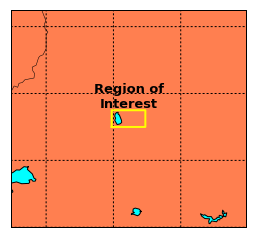

In [6]:
# Save the form values
platform = product_values[0].value
product = product_values[1].value

# Get the pixel resolution of the selected product
resolution = products.resolution[products.name == product]
lat_dist = resolution.values[0][0]
lon_dist = resolution.values[0][1]

# Get the extents of the cube
descriptor = api.get_descriptor({'platform': platform})[product]

min_date = descriptor['result_min'][0]
min_lat = descriptor['result_min'][1]
min_lon = descriptor['result_min'][2]

min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)

min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)

max_date = descriptor['result_max'][0]
max_lat = descriptor['result_max'][1] 
max_lon = descriptor['result_max'][2] 

max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

max_lat_rounded = round(max_lat, 3)
max_lon_rounded = round(max_lon, 3) 

# Display metadata
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon_dist,
                         min_lat_rounded, max_lat_rounded, lat_dist)

show_map_extents(min_lon_rounded, max_lon_rounded, min_lat_rounded, max_lat_rounded)

**Execute the following code and then use the generated form to choose the extents of your desired data.**

In [7]:
extent_values = create_extents_gui(min_date_str, max_date_str,
                                   min_lon_rounded, max_lon_rounded,
                                   min_lat_rounded, max_lat_rounded)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


**Now that we have filled out the above two forms, we have enough information to query our data cube.** The following code snippet ends with the actual Data Cube query, which will return the dataset with all the data matching our query.

In [8]:
# Save form values
start_date = datetime.strptime(extent_values[0].value, '%Y-%m-%d')
end_date = datetime.strptime(extent_values[1].value, '%Y-%m-%d')
min_lon = extent_values[2].value
max_lon = extent_values[3].value
min_lat = extent_values[4].value
max_lat = extent_values[5].value

# Query the Data Cube
dataset_in = dc.load(platform=platform,
                     product=product,
                     time=(start_date, end_date),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat))

**At this point, we have finished accessing our data cube and we can turn to analyzing our data.** In this example, we will run the fractional coverage algorithm as presented in Guerschman.
*****
For more information on the fractional coverage algorithm, refer to:
Guerschman, Juan P., et al. (2015) "Assessing the effects of site heterogeneity and soil properties when unmixing photosynthetic vegetation, non-photosynthetic vegetation and bare soil fractions from Landsat and MODIS data." Remote Sensing of Environment 161: 12-26.
*****
**Create a cloudfree, most-recent pixel mosaic from the retrieved dataset.** The fractional coverage algorithm will then be applied to the mosaic.

In [9]:
cfmask = dataset_in.cf_mask
clean_mask = np.reshape(np.in1d(cfmask.values.reshape(-1), [0]),
                                cfmask.values.shape)

mosaic = create_mosaic(dataset_in, clean_mask)

mosaic_cfmask = mosaic.cf_mask
mosaic_clean_mask = np.in1d(mosaic_cfmask.values.reshape(-1), [0])

Clean and format data so it is analysis-ready.

In [10]:
band_stack = []

for band in [mosaic.blue.values, mosaic.green.values, mosaic.red.values,
             mosaic.nir.values, mosaic.swir1.values, mosaic.swir2.values]:
    band = band.astype(np.float32)
    band = band * 0.0001 
    band = band.flatten()
    band_clean = np.full(band.shape, np.nan)
    band_clean[mosaic_clean_mask] = band[mosaic_clean_mask]
    band_stack.append(band_clean)
    
band_stack = np.array(band_stack).transpose()

In order to account for the non-linearities in the spectral mixing, the following code performs log transformations of the surface reflectance bands and interactive terms in the regression equations.

In [11]:
for b in range(6):
    band_stack = np.hstack((band_stack, np.expand_dims(np.log(band_stack[:, b]), axis=1)))
for b in range(6):
    band_stack = np.hstack((band_stack, np.expand_dims(np.multiply(band_stack[:, b], band_stack[:, b+6]), axis=1)))
for b in range(6):
    for b2 in range(b+1, 6):
        band_stack = np.hstack((band_stack, np.expand_dims(np.multiply(band_stack[:, b], band_stack[:, b2]), axis=1))) 
for b in range(6):
    for b2 in range(b+1, 6):
        band_stack = np.hstack((band_stack, np.expand_dims(np.multiply(band_stack[:, b+6], band_stack[:, b2+6]), axis=1)))
for b in range(6):
    for b2 in range(b+1, 6):
        band_stack = np.hstack((band_stack, 
                                np.expand_dims(np.divide(band_stack[:, b2] - band_stack[:, b], 
                                                         band_stack[:, b2] + band_stack[:, b]), 
                                               axis=1)))

band_stack = np.nan_to_num(band_stack)  # Now an n x 63 matrix

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Run fractional coverage algorithm.

In [12]:
ones = np.ones(band_stack.shape[0])
ones = ones.reshape(ones.shape[0], 1)
band_stack = np.concatenate((band_stack, ones), axis=1) # Now an n x 64 matrix

end_members = np.loadtxt('utils/endmembers_landsat.csv', delimiter=',') # Creates a 64 x 3 matrix

SumToOneWeight = 0.02
ones = np.ones(end_members.shape[1]) * SumToOneWeight
ones = ones.reshape(1, end_members.shape[1])
end_members = np.concatenate((end_members, ones), axis=0).astype(np.float64)

result = np.zeros((band_stack.shape[0], end_members.shape[1]), dtype=np.float64) # Creates an n x 3 matrix

for i in range(band_stack.shape[0]):
    if mosaic_clean_mask[i]:
        result[i, :] = (opt.nnls(end_members, band_stack[i, :])[0].clip(0, 2.54)*100).astype(np.int16)
    else:
        result[i, :] = np.ones((end_members.shape[1]), dtype=np.int16)*(255)

result = result.reshape(mosaic.latitude.size, mosaic.longitude.size, 3)

**The following plot visualizes the results of the fractional coverage algorithm.**

In [16]:
result

array([[[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       ..., 
       [[ 255.,  255.,  255.],
        [   4.,   28.,   65.],
        [   7.,   25.,   66.],
        ..., 
        [   4.,   62.,   32.],
        [   7.,   60.,   31.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [   7.,   32.,   58.],
        [   8.,   34.,   56.],
        ..., 
        [   6.,   59.,   32.],
        [   6.,   60.,   32.],
        [ 